# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [1]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [2]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    #lr=0.0009
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    #device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [4]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

/home/next/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [6]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [7]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [8]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

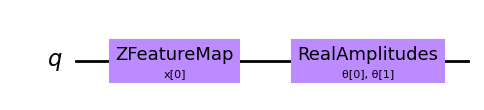

In [9]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

# we decompose the circuit for the QNN to avoid additional data copying
# Define and create QNN
nq=1
def create_qnn():
    feature_map = ZFeatureMap(nq, reps=2)
    ansatz = RealAmplitudes(nq, reps=1)
    qc = QuantumCircuit(nq)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn = create_qnn()

feature_map = ZFeatureMap(nq, reps=2)
ansatz = RealAmplitudes(nq, reps=1)
qc = QuantumCircuit(nq)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw('mpl')

In [10]:
from qiskit_machine_learning.connectors import TorchConnector
from torch import cat, no_grad, manual_seed

In [11]:
class QuantumCustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.fc = nn.Linear(512, nq)    
        self.qnn = TorchConnector(qnn)
        #self.fc2 = nn.Linear(pow(2, nq), CFG.target_size)
        
        # Remove fully connected layer and last two blocks
        self.model.fc = nn.Identity()
        self.model.layer4 = nn.Identity()
        self.model.layer3 = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.qnn(x)
        #x = self.fc2(x)
        
        return x

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [13]:
from torchsummary import summary

def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = QuantumCustomResNext(CFG.model_name, pretrained=True)
    #model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.NLLLoss()
    best_score = 0.
    best_loss = np.inf
    
    summary(model, (3, 128, 128))
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [14]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

In [15]:
if __name__ == '__main__':
    main(0)

========== training ==========


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]           8,192
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]           4,608
       BatchNorm2d-9          [-1, 128, 32, 32]             256
         Identity-10          [-1, 128, 32, 32]               0
             ReLU-11          [-1, 128, 32, 32]               0
         Identity-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]          32,768
      BatchNorm2d-14          [-1, 256,

Epoch 1 - avg_train_loss: 0.5155  avg_val_loss: 0.5022  time: 146s
Epoch 1 - Accuracy: 0.8283485045513654
Epoch 1 - Save Best Score: 0.8283 Model


EVAL: [49/49] Data 0.000 (0.004) Elapsed 0m 11s (remain 0m 0s) Loss: 0.7982(0.5022) 
Epoch: [2][1/192] Data 0.311 (0.311) Elapsed 0m 1s (remain 3m 28s) Loss: 0.4723(0.4723) Grad: 15.1360  
